# NLP Classifer: Twitter Sentiment on Apple and Google Products (Phase 4 Project Submission)

* Student name: Konnor Clark
* Student pace: self paced
* Scheduled project review date/time: 05.11.2023
* Instructor name: Morgan Jones
* Blog post URL: https://datadruid.blogspot.com/

## Project Goal:



This project aims to classify tweets from Twitter as containing positive, negative, or neutral sentiment about Apple or Google products.

## Overview and Business Understanding/Questions



My stakeholder is Google, who wishes to classify Twitter sentiment about both their own products as well as Apple products. 

These sentiments offer informal reviews of Google and Apple products, which can better help Google with future product development by gauging the failures and success of their own products and a major competitor's products. 

How can we categorize tweets as positive or negative?  

What kind of terms and hashtags are more likely to surround or embody positve or negative sentiment?

## Data Source and Exploration



This data comes from Data World at the following site: https://data.world/crowdflower/brands-and-product-emotions
Tweets regarding Google and Apple product were collected and contributors evaluated the tweets as containing positive, negative, or neutral content.

All features in the dataset were used. These were:

tweet_text

emotion_in_tweet_is_directed_at

is_there_an_emotion_directed_at_a_brand_or_product

There was some sort of error in the downloaded file that prevented accurate formatting.  I used Excel as an intermediary to import, edit, and then export the csv file again to fix the formatting issue. 

## Importing, Previewing, and Cleaning the Data




In [1]:
#Initial import
import pandas as pd

In [2]:
#Read the data and set variable
df = pd.read_csv('tweets.csv')

#Read the data and set variable (Colab)
# url = 'https://raw.githubusercontent.com/clarkkon/NLP-Classifier-Twitter-Sentiment-re-Apple-and-Google-Products/main/tweets.csv'
# df = pd.read_csv(url)

#Previw data
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,NaN,NaN,NaN
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,NaN,NaN,NaN
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,NaN,NaN,NaN
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,NaN,NaN,NaN
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,NaN,NaN,NaN


It seems that additional columns were created in my editing of the file's formatting.  These Unnamed columns are superfluous, so I will remove them. 

The main features are also a little wordy. Out of convenience, I'm going to simplify these column names. 

In [3]:
#Drop unnecessary columns
df = df.drop(columns=['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis=1)

#Rename features for convenience
df = df.rename(columns={'tweet_text': 'tweets', 
                        'emotion_in_tweet_is_directed_at': 'company', 
                        'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'})

In [4]:
#View data
df.head()

,tweets,company,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Great!  The excess columns have been removed and the main features have been simplified.

In [5]:
#Check for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9261 entries, 0 to 9260
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweets   9261 non-null   object
 1   company  3306 non-null   object
 2   emotion  9081 non-null   object
dtypes: object(3)
memory usage: 217.2+ KB


It looks like we're missing quite a few values for the company, and 180 values for emotion.  For the purposes of this classifer model, it may not be necessary to have all rows contain company information, so I will leave that for now.  However, the emotion class is essential, so let's take a look at what's happening there. 

In [6]:
#Preview emotion values
df.emotion.value_counts()

No emotion toward brand or product      5374
Positive emotion                        2976
Negative emotion                         570
I can't tell                             156
 USA                                       1
 Android                                   1
iPad                                       1
 Andro... {link} #sxsw #music #news"       1
 Texas                                     1
Name: emotion, dtype: int64

It seems that there are a few entries that have been mislabeled, perhaps shifted into an inappropriate column.  Since there are so few of these in comparison with the rest of the data, I am simply going to delete these mislabeled rows.

There are also 156 containing the string "I can't tell."  This will probably not be useful for our purposes, so I'm going to go ahead and delete any row that contains these uninformative values in the emotion column. 

In [7]:
#Remove outlying values
index_names = df[(df['emotion'] != 'No emotion toward brand or product') &
                (df['emotion'] != 'Positive emotion') &
                (df['emotion'] != 'Negative emotion')].index
df.drop(index_names, inplace = True)

In [8]:
#Confirm removal of outliers
df.emotion.value_counts()

No emotion toward brand or product    5374
Positive emotion                      2976
Negative emotion                       570
Name: emotion, dtype: int64

In [9]:
#Preview data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8920 entries, 0 to 9260
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweets   8920 non-null   object
 1   company  3280 non-null   object
 2   emotion  8920 non-null   object
dtypes: object(3)
memory usage: 278.8+ KB


Great, so now our three classes make sense and all null or useless values have been removed.  It still looks like over half of the rows do not have company information, but I will leave it for now in case this is somehow helpful for the classifier.  I am curious as to the values in this column

In [10]:
#Preview company values
df.company.value_counts()

iPad                               941
Apple                              659
iPad or iPhone App                 469
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: company, dtype: int64

The labels are subdivided within the larger categories of Apple or Google.  While I am not sure the distinction between "iPad," "iPad or iPhone App," and "iPhone," it is possible that the model will be better able to evaluate an emotion based on these subcategories (perhaps a label of 'iPhone' is more likely to be associated with a negative emotion, for example), so I will leave these as they are for now. Again, it may be easier to simply remove this column in the future. 

## Manipulating the Data

Below I standardize the tweets so they are all lowercase

In [11]:
#Standardize tweets to lowercase
df.tweets = df.tweets.str.lower()
df.head()

,tweets,company,emotion
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion


I now need to tokenize the tweets.

In [12]:
#Tokenizer import
from nltk.tokenize import RegexpTokenizer

#Token pattern
basic_token_pattern = r"(?u)\b\w\w+\b"

#Tokenizer variable
tokenizer = RegexpTokenizer(basic_token_pattern)

#Apply tokenizer
df["tweets_tokenized"] = df["tweets"].apply(tokenizer.tokenize)

#Preview change
df.head()

,tweets,company,emotion,tweets_tokenized
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, have, 3g, iphone, after, hrs, tweet..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, can, not, wait, for, ipad, also, ..."
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, this, year, festival, isn, as, cr..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, maris..."


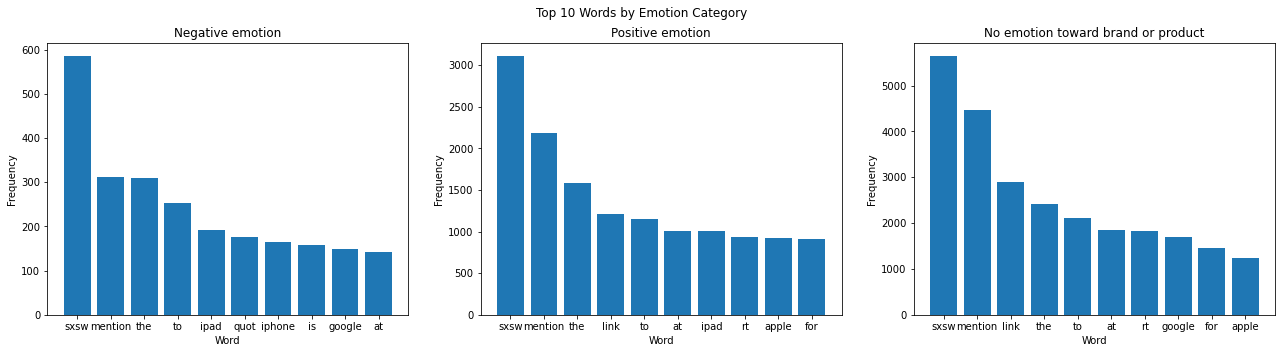

In [13]:
#Import frequency distribution and plot
import nltk
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

#Function to plot Top 10 tokens by emotion
def plot_frequency_by_emotion(dataframe):
    # Tokenize words in the 'tweets_tokenized' column and creating a list of all tokens
    all_tokens = [token for tweet in df['tweets_tokenized'] for token in tweet]

    # Calculate frequency distribution for all tokens
    all_tokens_freq = FreqDist(all_tokens)

    # Set up subplots for each emotion category
    fig, axes = plt.subplots(1, 3, figsize=(22,5))

    # Plot frequency distribution for each category
    for index, emotion in enumerate(df['emotion'].unique()):
        # Filter dataframe by emotion category and tokenizing words
        category_tokens = [token for tweet in df[df['emotion'] == emotion]['tweets_tokenized'] for token in tweet]

        # Calculate frequency distribution for this category
        category_tokens_freq = FreqDist(category_tokens)

        # Get top 10 most common tokens and their counts
        top_10_tokens = [token[0] for token in category_tokens_freq.most_common(10)]
        top_10_counts = [token[1] for token in category_tokens_freq.most_common(10)]

        # Plot bar chart of top 10 tokens and their counts
        ax = axes[index]
        ax.bar(top_10_tokens, top_10_counts)
        ax.set_title(emotion)
        ax.set_xlabel('Word')
        ax.set_ylabel('Frequency')

    plt.suptitle('Top 10 Words by Emotion Category')
    plt.show()

plot_frequency_by_emotion(df)


Informative! It seems that these tweets were potentially collected during a South by Southwest conference.. There looks to be significant overlap in these top 10 terms and there are stopwords that I will eventually remove.  

###Build and Evaluate a Baseline Model

In [14]:
#Import train test split
from sklearn.model_selection import train_test_split

X = pd.DataFrame(data=df.tweets)
y = df.emotion

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweets"])


In [16]:
# We should still have the same number of rows
assert X_train_vectorized.shape[0] == X_train.shape[0]

# The vectorized version should have 10 columns, since we set
# max_features=10
assert X_train_vectorized.shape[1] == 10

In [17]:
# Import relevant class and function
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.60364146, 0.60406447, 0.60406447, 0.6033637 , 0.6033637 ])

In [18]:
#Comparing the above cv with the class balance
y_train.value_counts(normalize=True)

No emotion toward brand or product    0.603700
Positive emotion                      0.335342
Negative emotion                      0.060959
Name: emotion, dtype: float64

If we were to guess the plurality every time, "No emotion," we could expect a 60.37% accuracy.  So right now this model is actually a reduction in accuracy at an average of 60.34%.

Let's see if removing stopwords helps.

###Build a Second Model without Stopwords

In [19]:
#Download and import stopwords
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')

In [20]:
#Function to remove stopwords
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [21]:
#Remove stopwords from tweets_tokenized
df.tweets_tokenized = df.tweets_tokenized.apply(remove_stopwords)
df.head()

,tweets,company,emotion,tweets_tokenized
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, 3g, iphone, hrs, tweeting, rise_aus..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, year, festival, crashy, year, iph..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


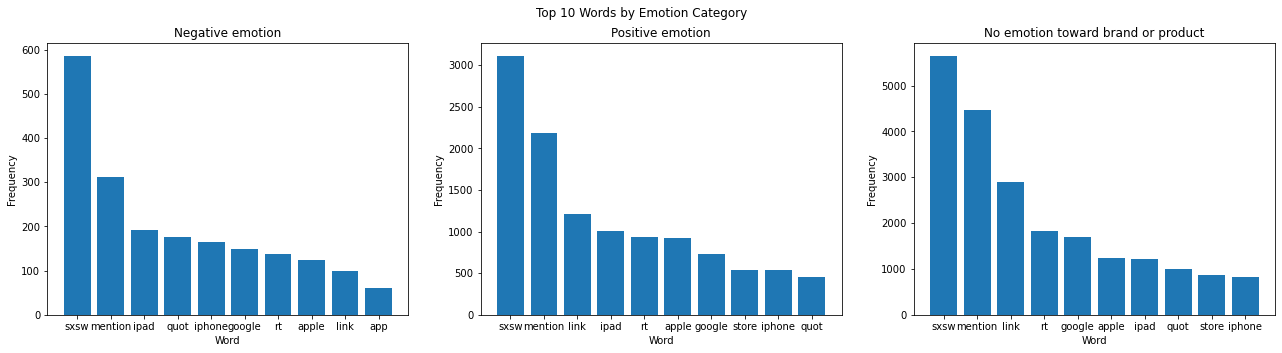

In [22]:
#Visualize token frequency by emotion without stopwords
plot_frequency_by_emotion(df)

So the stopwords have been removed, great!  There still seems to be significant overlap between the words in each category, for example the words sxsw, mention, ipad, apple, iphone, google, link, rt, and quot are found in all three, and 'store' is found in two out of the three.  Since these terms are so common among all three, they may not be particularly useful for the model to distiguish between these three categories.  Before iterating our next model, I will remove them.  

In [23]:
#Confirm length of stopword list
print("Original list length:", len(stopwords_list))

#Add new words
new_words = ['sxsw', 'mention', 'ipad', 'quot', 'iphone', 'google', 'rt', 'apple', 'link', 'quot', 'store']
stopwords_list.extend(new_words)

#Verify new length of stopword list
print("List length after adding 'for':", len(stopwords_list))

Original list length: 179
List length after adding 'for': 190


In [24]:
#Apply stopwords removal
df.tweets_tokenized = df.tweets_tokenized.apply(remove_stopwords)

Let's update the dataframe with the appended list and see the frequency distribution.

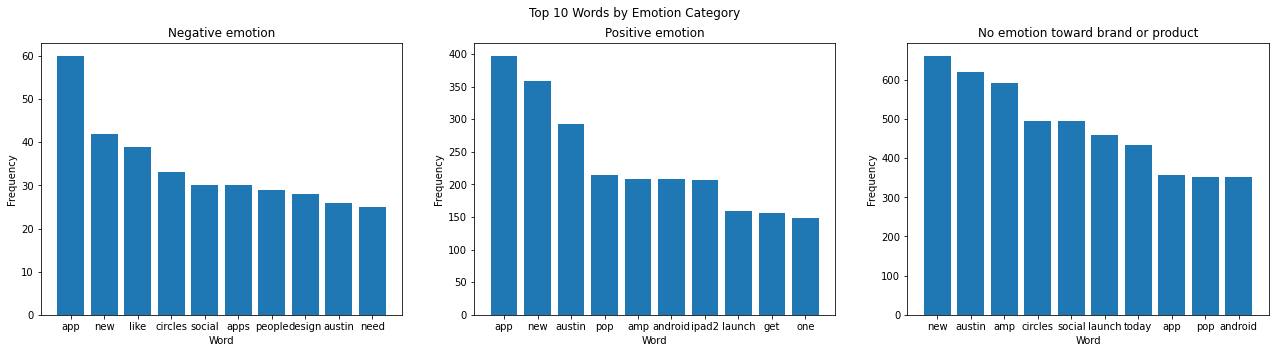

In [25]:
#Visualize token frequency by emotion with new stopwords
plot_frequency_by_emotion(df)

Ok, that removed much of our original top 10, but it looks like there is still some significant overlap.  The words app, new, and austin are in three of the top 10, while social, amp, circles, launch, pop, and android are in two.  Let's move ahead and see how this first change affects the accuracy of our model. 

In [26]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list
)

# Fit the vectorizer on X_train and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweets"])

In [27]:
# Evaluate the classifier on X_train_vectorized and y_train
stopwords_removed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
stopwords_removed_cv

array([0.59803922, 0.61667835, 0.6152768 , 0.61387526, 0.60406447])

In [28]:
#Compare original model to new model
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.6036995597117614
Stopwords removed: 0.6095868200118169


The slightest improvement.  Rather than keep adding to the stopword list, let's see if stemming helps the model improve.

### Build a Third Model with Stemmer

In [29]:
#Import stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")

#Stemmer function
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

I also need to stem the stopwords

In [30]:
#Stem stopwords
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [31]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweets"])

In [32]:
# Evaluate the classifier on X_train_vectorized and y_train
stemmed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
stemmed_cv

array([0.60084034, 0.61457603, 0.61247372, 0.60967064, 0.60546601])

In [33]:
#Compare best model with stemmer addition
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())

Stopwords removed: 0.6095868200118169
Stemmed:           0.6086053482360008


An ever so slightly worse model. So the best model so far is removing the stop words (with the additional stop words appended).

Right now I am only allowing the model to look at the tf-idf of the top 10 most frequent tokens. If I allow it to look at all possible tokens, that could lead to high dimensionality issues, but let's take a look at how long our X_train is and figure out what we could change our max_features to. 

###Build Fourth Model with Best TF-IDF max_features 

In [34]:
#Check length of X_train
len(X_train)

7136

Setting max_features to 7136 would mean an equal number of rows and columns, something that can cause problems for many model algorithms.

I will try increasing max_features from 10 to 200.  Since I will be iterating more models, I will build a function to make the process a little less repetetive.

In [35]:
#Model function
def model(maximum_features):
  tfidf = TfidfVectorizer(
      max_features=maximum_features,
      stop_words=stemmed_stopwords,
      tokenizer=stem_and_tokenize,
      token_pattern=None
)
  # Initialize the Naive Bayes classifier
  baseline_model = MultinomialNB()

  #Transform the training data into feature vectors
  X_train_vectorized = tfidf.fit_transform(X_train["tweets"])

  # Calculate the cross-validation score
  cv_score = cross_val_score(baseline_model, X_train_vectorized, y_train)
  return cv_score

In [36]:
#Create model with 200 max_features for TF-IDF
model_200 = model(200)
model_200

array([0.65546218, 0.63980378, 0.63770147, 0.63910301, 0.63139453])

In [37]:
#Create model with 500 max_features for TF-IDF
model_500 = model(500)
model_500

array([0.67016807, 0.66012614, 0.66152768, 0.66222845, 0.64751226])

The model keeps getting better.  Rather than check every value for max_features, I will create a loop to figure it out the closest max_feature value.

In [38]:
import numpy as np

# Define the range of maximum features to test
max_features_range = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

# Initialize an empty dictionary to store the cross-validation scores
cv_scores_dict = {}

# Iterate through each value of maximum features and calculate the cross-validation score
for max_features in max_features_range:
    # Initialize the TfidfVectorizer with the current value of maximum features
    tfidf = TfidfVectorizer(
        max_features=max_features,
        stop_words=stemmed_stopwords,
        tokenizer=stem_and_tokenize,
        token_pattern=None
    )

    # Transform the training data into feature vectors
    X_train_vectorized = tfidf.fit_transform(X_train["tweets"])

    # 
    # baseline_model = MultinomialNB()

    # Calculate the cross-validation score
    cv_score = np.mean(cross_val_score(baseline_model, X_train_vectorized, y_train, cv=5))

    # Store the cross-validation score in the dictionary
    cv_scores_dict[max_features] = cv_score

# Print the dictionary of cross-validation scores
print(cv_scores_dict)

# Find the maximum cross-validation score and the corresponding value of maximum features
max_cv_score = max(cv_scores_dict.values())
best_max_features = [k for k, v in cv_scores_dict.items() if v == max_cv_score][0]

# Print the best value of maximum features and the corresponding cross-validation score
print("Best maximum features:", best_max_features)
print("Cross-validation score:", max_cv_score)

{500: 0.6603125202428554, 1000: 0.6589119600187657, 1500: 0.6618543142554849, 2000: 0.6618551975800832, 2500: 0.6625558702808384, 3000: 0.6624159124056069, 3500: 0.6600335859641684, 4000: 0.6611541322906177}
Best maximum features: 2500
Cross-validation score: 0.6625558702808384


Great, so our final model will have a max_features value of 2500.

In [39]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=2500,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize,
    token_pattern=None
)
# baseline_model = MultinomialNB()

#Fit the vectorizer on X_train and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweets"])

# Evaluate the classifier on X_train_vectorized and y_train
final_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
final_cv

array([0.66386555, 0.66783462, 0.67203924, 0.66012614, 0.64891381])

In [40]:
# Instantiate a MultinomialNB classifier
final_model = MultinomialNB()

#Train final model with X_train vectorized to include stop words and tokenizer
final_model.fit(X_train_vectorized, y_train)

#Compute accuracy of final model
final_model.score(X_train_vectorized, y_train)

0.7449551569506726

Ok, so some difference between the cv score (64.89%) and this accuracy score (74.5%), which means we have some overfitting.  The cv is better indicator for new, unseen data.

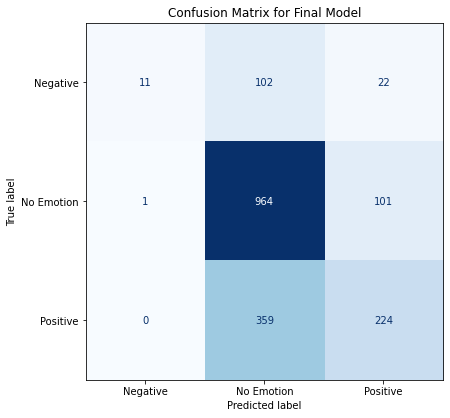

In [41]:
#Imports for confusion matrices
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Transform the test data using the vectorizer
X_test_vectorized = tfidf.transform(X_test["tweets"])

# Make predictions on the test data
y_pred = final_model.predict(X_test_vectorized)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 15))
plot_confusion_matrix(final_model, X_test_vectorized, y_test, cmap=plt.cm.Blues, ax=ax)
ax.images[-1].colorbar.remove()

#Simplify the labels
ax.set_xticklabels(['Negative', 'No Emotion', 'Positive'])
ax.set_yticklabels(['Negative', 'No Emotion', 'Positive'])

#Set title
plt.title('Confusion Matrix for Final Model')

#Plot
plt.show()

It looks like the model is best at intepreting tweets with No Emotion. It is better at interpreting a positive emotion tweet than a negative one, but there is a lean toward labeling positive and negative emotion tweets as no emotion. 

## Conclusion and Recommendation

This final model interprets tweets with no emotion relatively accurately. This is the plurality of the dataset. 

If Google is interested in an accurate model that will correctly predict a negative, positive, or emotionless tweet, further iterations with the current dataset could prove fruitful. 

There is still a high level of overlap between the top 10 tokens of the three classes.  Further removal of these overlapping tokens may help the model better distinguish between the three classes.

Beyond this dataset, a higher sample of positive and negative tweets could help the model in its predictive accuracy.  The vast majority of tweets in this dataset were labeled as containing no emotion.  If Google is interested in positive or negative tweets, this dataset could be extended with more relevant information.  

In summary, this model provides a adequate baseline for classifying emotionless tweets. For further developement,  high frequency terms that overlap across the three classes (positive, negative, no emotion) could be removed from the dataset while additional positively and negatively-labeled tweets should be introduced to the dataset.  

Once this overlap is reduced, the additional data is included, and the cross-validation score is improved for the three classes, the implementing the model on new data can begin. An analysis of the new data's tokens and the corresponding information in each of the three classes will provide Google keen insights for future product development.  
